In [1]:
#Loading libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import uproot3
import uproot
import math
import pickle
import csv
from importlib import reload

import Utilities.Constants as Constants
import Utilities.Functions as Functions
import Utilities.Plotter as PT
from Utilities.ipython_exit import exit

print("Successful!")


Successful!


In [2]:
Params_pyhf = {"Stats_only":False,
               "Use_flat_sys":False,
               "Use_part_only":False,
               "Num_bins_for_calc":4,
               "Use_toys":False,
               "Num_toys":100,
               "Load_lepton_hists":True,
               "Load_pi0_hists":False,
               "Flat_bkg_overlay_frac":0.3,
               "Flat_bkg_dirt_frac":0.75,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.2, #This is very conservative, could be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3, #This comes from the KDAR flux uncertainty.
               "Overlay_detvar_frac":0.3,
               "Load_lepton_dirac":False,
               "Load_pi0_dirac":False,
               "Load_single_r1_file":False}

Functions.pyhf_params(Params_pyhf)


Using fully evaluated systematic uncertainty for background. Dirt error is 75.0%.
Using fully evaluated systematic uncertainty for signal. Using 30.0% flux error.


In [3]:
if Params_pyhf["Load_lepton_hists"] == True: 
    name_type="ee"
    HNL_masses = Constants.HNL_mass_samples
if Params_pyhf["Load_pi0_hists"] == True: 
    name_type="pi0"
    HNL_masses = Constants.HNL_mass_pi0_samples
if Params_pyhf["Load_lepton_dirac"] == True:
    name_type="ee_dirac"
    HNL_masses = Constants.HNL_ee_dirac_mass_samples
if Params_pyhf["Load_pi0_dirac"] == True:
    name_type="pi0_dirac"
    HNL_masses = Constants.HNL_pi0_dirac_mass_samples
    
BDT_name = "_full_Finished_10"

filename = name_type+BDT_name

hist_dict_run1, hist_dict_run3, theta_dict = Functions.New_Load_pyhf_files(f"{filename}.root",
                                                                           Params_pyhf, HNL_masses = HNL_masses)


No missing histograms in Run1
thetas are:
{2: 0.1, 10: 0.01, 20: 1e-04, 50: 1e-04, 100: 1e-04, 150: 1e-04}
Done


In [4]:
#Loading My BDT histograms
# loc_hists = 'Uncertainties/'

# # name_type = Functions.Get_signal_name_type(Params_pyhf)
# if Params_pyhf["Load_lepton_hists"] == True: 
#     name_type="ee"
#     HNL_masses = Constants.HNL_mass_samples
# if Params_pyhf["Load_pi0_hists"] == True: 
#     name_type="pi0"
#     HNL_masses = Constants.HNL_mass_pi0_samples
# if Params_pyhf["Load_lepton_dirac"] == True:
#     name_type="ee_dirac"
#     HNL_masses = Constants.HNL_ee_dirac_mass_samples
# if Params_pyhf["Load_pi0_dirac"] == True:
#     name_type="pi0_dirac"
#     HNL_masses = Constants.HNL_pi0_dirac_mass_samples
    
# BDT_name = "_full_Finished_10"

# filename = name_type+BDT_name

# hist_dict_run1 = {}
# hist_dict_run3 = {}
# theta_dict = {}

# #Loading in the .root files
# if Params_pyhf["Load_lepton_hists"] == True:
#     for HNL_mass in Constants.HNL_mass_samples:
#         # hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_FINAL_3.root')
#         # hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_FINAL_3.root')
#         hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}_{filename}.root')
#         hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}_{filename}.root')
#         theta_dict[HNL_mass] = hist_dict_run1[HNL_mass]["theta"].values()[0] #assuming scaled theta is the same for all runs, only 1 value saved
    
# if Params_pyhf["Load_pi0_hists"] == True:
#     pi0_dict_run1, pi0_dict_run3 = {}, {}
#     for HNL_mass in Constants.HNL_mass_pi0_samples:
#         # hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_FINAL_3.root')
#         # hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_FINAL_3.root')
#         hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}_{filename}.root')
#         hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}_{filename}.root')
#         theta_dict[HNL_mass] = hist_dict_run1[HNL_mass]["theta"].values()[0]

# #list_of_dicts = [hist_dict_run1, hist_dict_run3] #Add run2 when available, not using yet

# #Constants

# theta_dict[HNL_mass] = hist_dict_run1[HNL_mass]["theta"].values()[0]
# theta_squared = Constants.theta_mu_4*Constants.theta_mu_4

# print(theta_dict)

# print("Success")


In [5]:
def Get_uncertainty_dicts(hist_dict, Params):
    """
    Given a dict of uproot files will return the total signal uncertainty, bkg uncertainty and bin dicts.
    """
    overlay_dict, dirt_dict, EXT_dict = {}, {}, {}
    signal_dict = {}
    bins_dict = {}
    bins_cent_dict = {}
    tot_uncertainty_dict = {}
    sig_sys_err = {}
    data = {}
    
    for HNL_mass in hist_dict:
        overlay_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[0]
        dirt_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_dirt'].to_numpy()[0]
        EXT_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_EXT'].to_numpy()[0]
        signal_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].to_numpy()[0]

        tot_uncertainty = [hist_dict[HNL_mass]['ppfx_uncertainty_frac'].to_numpy()[0]*hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[0], #overlay ppfx error
                           hist_dict[HNL_mass]['Genie_uncertainty_frac'].to_numpy()[0]*hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[0], #overlay genie error
                           hist_dict[HNL_mass]['Reinteraction_uncertainty_frac'].to_numpy()[0]*hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[0], #overlay reinteraction error
                           hist_dict[HNL_mass]['overlay_DetVar_uncertainty_frac'].to_numpy()[0]*hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[0], #overlay detector variation error
                           hist_dict[HNL_mass]['bkg_dirt'].to_numpy()[0]*Params["Flat_bkg_dirt_frac"], #dirt flat systematic error
                           hist_dict[HNL_mass]['bkg_overlay'].errors(), #stat error
                           hist_dict[HNL_mass]['bkg_dirt'].errors(), #stat error
                           hist_dict[HNL_mass]['bkg_EXT'].errors()] #stat error

        tot_sig_unc = [hist_dict[HNL_mass]['signal'].errors(),
                       # hist_dict[HNL_mass]["signal_DetVar_uncertainty"].values(),
                       hist_dict[HNL_mass]['overlay_DetVar_uncertainty_frac'].to_numpy()[0]*hist_dict[HNL_mass]['signal'].to_numpy()[0],
                       hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]]

        sig_sys_err[HNL_mass] = Functions.add_all_errors(tot_sig_unc)

        tot_uncertainty_dict[HNL_mass] = Functions.add_all_errors(tot_uncertainty)

        bins_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
        bins_cent_dict[HNL_mass]=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2

        data[HNL_mass] = hist_dict[HNL_mass]['data'].values()

    bkgs_dict = {'overlay':overlay_dict, 'dirtoverlay':dirt_dict, 'beamoff':EXT_dict}
    
    return signal_dict, bkgs_dict, data, sig_sys_err, tot_uncertainty_dict, bins_dict, bins_cent_dict
    

In [6]:
signal_dict_r1, bkgs_dict_r1, data_r1, sig_sys_err_r1, tot_uncertainty_dict_r1, bins_dict_r1, bins_cent_dict_r1 = Get_uncertainty_dicts(hist_dict_run1, 
                                                                                                                                        Params_pyhf)
signal_dict_r3, bkgs_dict_r3, data_r3, sig_sys_err_r3, tot_uncertainty_dict_r3, bins_dict_r3, bins_cent_dict_r3 = Get_uncertainty_dicts(hist_dict_run3, 
                                                                                                                                        Params_pyhf)


In [7]:
def make_overflow_bin(bins_dict, bins_cents_dict):
    """
    For making the final "overflow" bin the same size as the previous bins, i.e one integer in width.
    """
    bins_overflow, bins_cent_overflow = {}, {}
    for HNL_mass in bins_dict:
        overflow_bin = bins_cents_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin centre val. 
        bins_cent_overflow[HNL_mass] = bins_cents_dict[HNL_mass].copy()
        bins_cent_overflow[HNL_mass][-1] = overflow_bin
        bins_overflow[HNL_mass] = bins_dict[HNL_mass].copy()
        bins_overflow[HNL_mass][-1] = bins_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin end val. 
    return bins_overflow, bins_cent_overflow

bins_overflow_r1, bins_cents_overflow_r1 = make_overflow_bin(bins_dict_r1, bins_cent_dict_r1)
bins_overflow_r3, bins_cents_overflow_r3 = make_overflow_bin(bins_dict_r3, bins_cent_dict_r3)

def make_xlims_dict(bins_dict, lower = None):
    """
    Making a dict of xlims for plotting several mass points at once.
    Also returns a dict of xticks for the purpose of indicating the overflow.
    """
    xlims_adjusted, xticks_adjusted = {}, {}
    for HNL_mass in bins_dict:
        if isinstance(lower,(int, float)): lower_val = lower
        else: lower_val = bins_dict[HNL_mass][0]
        xlims_adjusted[HNL_mass] = [lower_val,bins_dict[HNL_mass][-1]]
        ticks = np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], 1)
        ticks_strings = []
        for val in ticks:
            ticks_strings.append(str(int(val)))
        ticks_strings[-1] = str(ticks_strings[-1])+"+"
        xticks_adjusted[HNL_mass] = ticks_strings
        
    return xlims_adjusted, xticks_adjusted


In [13]:
def Plot_BDT_output_systematics(signal={}, tot_uncertainty_dict={}, sig_unc={}, bkgs={}, bins_cent_dict={}, bins_dict={}, colours={}, ALPHA=1.0, xlims=[0,5.0],
                                figsize=[12,8], density=False, legloc="upper right",legsize=22,
                                logy=False, savefig=False, save_str="", Run="_", HNL_scale=1.0,scale_up=[], thetas=[], order=[],
                                sig_sys=False,HNL_scale_label=False):
    """
    This should take the histograms which have already been binned and scaled and plot the total uncertainties on bkg.
    Therefore it will display what is being fed into the limit setting software.
    """
    if(isinstance(HNL_scale, float)): print("Scaling by a single number for all")
    if(isinstance(HNL_scale, dict)): print("Scaling each mass point individually")
    if(signal=={}): raise Exception("Specify HNL sample masses")
    if(bkgs=={}): raise Exception("Specify background samples")
    if(bins_cent_dict=={}): raise Exception("Specify bin centres")
    if(bins_dict=={}): raise Exception("Specify bins")
    if(colours=={}): colours = {'overlay':Constants.sample_colours['overlay'],
                                'dirtoverlay':Constants.sample_colours['dirtoverlay'],
                                'beamoff':Constants.sample_colours['beamoff'],
                                'signal':Constants.sample_colours['signal']}
    if(order==[]): order = ["beamoff","overlay","dirtoverlay"] #From bottom to top in stack
    if(thetas==[]): print("Haven't entered thetas, can't calculate scalings") 
    
    if logy == True:
        logscale="log"
    elif logy == False:
        logscale="linear"
    
    for HNL_mass in signal.keys():
        plt.figure(figsize=figsize,facecolor='white')
        if(isinstance(HNL_scale, dict)):
            HNL_scaling=HNL_scale[HNL_mass]
        else: HNL_scaling = HNL_scale
        print("HNL scale is " + str(HNL_scaling))
        
        bins_cents=[bins_cent_dict[HNL_mass], bins_cent_dict[HNL_mass], bins_cent_dict[HNL_mass]]
        
        if HNL_scale_label==False: HNL_label = f"{HNL_mass} MeV HNL"
        if HNL_scale_label==True: 
            theta = thetas[HNL_mass]
            theta_2 = theta**2
            new_theta_2 = np.sqrt(scale_up[HNL_mass])*theta_2
            theta_2_label = PT.sci_notation(new_theta_2, decimal_digits=0)
            HNL_label = f"{HNL_mass} MeV HNL \n" + r"$|U_{\mu4}|^2$ = " + theta_2_label
        
        labels_sample = {'overlay':fr"In-Cryo $\nu$",
                         'dirtoverlay':fr"Out-Cryo $\nu$",
                         'beamoff':f"Beam-Off",
                         'signal':HNL_label}
                         #'signal':f"{HNL_mass} MeV HNL"}

        bkg_scores, bkg_colors, labels = [], [], []
        for sample in order:
            bkg_scores.append(bkgs[sample][HNL_mass])
            bkg_colors.append(colours[sample])
            labels.append(labels_sample[sample])
        
        hist_placeholder = np.histogram(bins_cents, weights=bkg_scores, range=xlims)[0] #Just for calculating ylims
        
        hist_full_placeholder = np.histogram(bins_cents, weights=bkg_scores, bins=bins_dict[HNL_mass])[0] #For making the error bars
        numbins = len(np.where( bins_cent_dict[HNL_mass] > xlims[0] )[0])+1 #Getting the number of bins that will be plotted with the given xlims range
               
        plot=plt.hist(bins_cents,
                      label=labels,
                      bins=bins_dict[HNL_mass],
                      histtype="stepfilled",
                      stacked=True,linewidth=2,edgecolor="black",
                      weights=bkg_scores, color=bkg_colors, alpha=ALPHA)
        
        tot_uncrt = tot_uncertainty_dict[HNL_mass]
        upvals_placeholder = hist_full_placeholder+tot_uncrt
        lowvals_placeholder = hist_full_placeholder-tot_uncrt
        upvals = np.append(upvals_placeholder, [0])
        lowvals = np.append(lowvals_placeholder, [0])
        
        maxy = max(upvals[-numbins:])
        
        plt.fill_between(bins_dict[HNL_mass], lowvals, upvals, step="post",color="grey",alpha=0.3,zorder=2)

        plt.hist(bins_cent_dict[HNL_mass],
                 weights=signal[HNL_mass]*HNL_scaling,
                 bins=bins_dict[HNL_mass],
                 lw=4, edgecolor=colours['signal'], label=labels_sample["signal"], histtype="step")
        
        sig_placeholder = np.histogram(bins_cent_dict[HNL_mass], weights=signal[HNL_mass]*HNL_scaling, bins=bins_dict[HNL_mass])[0] #For making the error bars
        sig_down_placeholder = sig_placeholder-sig_unc[HNL_mass]*HNL_scaling
        sig_up_placeholder = sig_placeholder+sig_unc[HNL_mass]*HNL_scaling
        sig_down = np.append(sig_down_placeholder, [0])
        sig_up = np.append(sig_up_placeholder, [0])
        
        if sig_sys == True:
            plt.rcParams.update({'hatch.color': colours['signal']})
            plt.fill_between(bins_dict[HNL_mass], sig_down, sig_up, step="post",hatch='//',alpha=0,zorder=2,lw=2)
        
        ylims = [0,maxy*1.1]
        plt.legend(loc=legloc,frameon=True, fontsize = legsize)
        
        plt.xlim(xlims)
        if logy==False:
            plt.ylim(ylims)
        
        plt.xlabel('BDT score', fontsize=30)
        plt.ylabel('Events', fontsize=30)
        plt.yscale(logscale)
        plt.tight_layout()
        if savefig == True:
            plt.savefig("plots/BDT_output/Final_histograms/BDT_output_" + Run + "_" + str(HNL_mass) + "MeV_" + logscale + save_str + ".pdf")
            plt.savefig("plots/BDT_output/Final_histograms/BDT_output_" + Run + "_" + str(HNL_mass) + "MeV_" + logscale + save_str + ".png")
        plt.show()
        
def Plot_BDT_output_systematics_data(signal={}, tot_uncertainty_dict={}, sig_unc={}, bkgs={}, data={}, bins_cent_dict={}, bins_dict={},
                                     colours={}, ALPHA=1.0, xlims=[], xticks=[], upper_y=[],
                                     figsize=[12,10], density=False, legloc="upper right",legsize=22,
                                     logy=False, savefig=False, save_str="", Run="_", HNL_scale=1.0,scale_up=[], thetas=[], order=[], 
                                     sig_sys=False, HNL_scale_label=False, stacked=False, title_name=None, textpos=None, plot_text=None, textsize=None):
    """
    This should take the histograms which have already been binned and scaled and plot the total uncertainties on bkg.
    Therefore it will display what is being fed into the limit setting software. INCLUDING the data.
    """
    if(isinstance(HNL_scale, float)): print("Scaling by a single number for all")
    if(isinstance(HNL_scale, dict)): print("Scaling each mass point individually")
    if(signal=={}): raise Exception("Specify HNL sample masses")
    if(bkgs=={}): raise Exception("Specify background samples")
    if(data=={}): raise Exception("Specify data sample")
    if(bins_cent_dict=={}): raise Exception("Specify bin centres")
    if(bins_dict=={}): raise Exception("Specify bins")
    if(colours=={}): colours = {'overlay':Constants.sample_colours['overlay'],
                                'dirtoverlay':Constants.sample_colours['dirtoverlay'],
                                'beamoff':Constants.sample_colours['beamoff'],
                                'signal':Constants.sample_colours['signal']}
    if(order==[]): order = ["beamoff","overlay","dirtoverlay"] #From bottom to top in stack
    if(thetas==[]): print("Haven't entered thetas, can't calculate scalings") 
    
    if logy == True:
        logscale="log"
    elif logy == False:
        logscale="linear"
    
    for HNL_mass in signal.keys():
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=100)
        
        if xlims==[]: xlims_plot=[bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]]
        elif(isinstance(xlims, dict)): xlims_plot = xlims[HNL_mass]
        else: xlims_plot=xlims
        
        #----primary plot----#
        plt.sca(ax[0])
        
        if isinstance(title_name, str): plt.title(title_name, fontsize=24)
        
        if(isinstance(HNL_scale, dict)):
            HNL_scaling=HNL_scale[HNL_mass]
        else: HNL_scaling = HNL_scale
        print("HNL scale is " + str(HNL_scaling))
        
        bins_cents=[bins_cent_dict[HNL_mass], bins_cent_dict[HNL_mass], bins_cent_dict[HNL_mass]]
        
        if HNL_scale_label==False: HNL_label = f"{HNL_mass} MeV HNL"
        if HNL_scale_label==True: 
            theta = thetas[HNL_mass]
            theta_2 = theta**2
            new_theta_2 = np.sqrt(scale_up[HNL_mass])*theta_2
            theta_2_label = PT.sci_notation(new_theta_2, decimal_digits=0)
            HNL_label = f"{HNL_mass} MeV HNL \n" + r"$|U_{\mu4}|^2$ = " + theta_2_label
        
        labels_sample = {'overlay':fr"In-Cryo $\nu$",
                         'dirtoverlay':fr"Out-Cryo $\nu$",
                         'beamoff':f"Beam-Off",
                         'signal':HNL_label}
                         #'signal':f"{HNL_mass} MeV HNL"}

        bkg_scores, bkg_colors, labels = [], [], []
        for sample in order:
            bkg_scores.append(bkgs[sample][HNL_mass])
            bkg_colors.append(colours[sample])
            labels.append(labels_sample[sample])
        
        hist_placeholder = np.histogram(bins_cents, weights=bkg_scores, range=xlims_plot)[0] #Just for calculating ylims
        
        hist_full_placeholder = np.histogram(bins_cents, weights=bkg_scores, bins=bins_dict[HNL_mass])[0] #For making the error bars
        numbins = len(np.where( bins_cent_dict[HNL_mass] > xlims_plot[0] )[0])+1 #Getting the number of bins that will be plotted with the given xlims range
        
        tot_uncrt = tot_uncertainty_dict[HNL_mass]
        upvals_placeholder = hist_full_placeholder+tot_uncrt
        lowvals_placeholder = hist_full_placeholder-tot_uncrt
        upvals = np.append(upvals_placeholder, [0])
        lowvals = np.append(lowvals_placeholder, [0])
        
        maxy = max(upvals[-numbins:])
        
        plot=plt.hist(bins_cents,
                      label=labels,
                      bins=bins_dict[HNL_mass],
                      histtype="stepfilled",
                      stacked=True,linewidth=2,edgecolor="black",
                      weights=bkg_scores, color=bkg_colors, alpha=ALPHA)
            
        plt.fill_between(bins_dict[HNL_mass], lowvals, upvals, step="post",color="grey",alpha=0.3,zorder=2)
        
        sig_placeholder = np.histogram(bins_cent_dict[HNL_mass], weights=signal[HNL_mass]*HNL_scaling, bins=bins_dict[HNL_mass])[0] #For making the error bars
        sig_down_placeholder = sig_placeholder-sig_unc[HNL_mass]*HNL_scaling
        sig_up_placeholder = sig_placeholder+sig_unc[HNL_mass]*HNL_scaling
        sig_down = np.append(sig_down_placeholder, [0])
        sig_up = np.append(sig_up_placeholder, [0])

        if stacked==False:
       
            plt.hist(bins_cent_dict[HNL_mass],
                     weights=signal[HNL_mass]*HNL_scaling,
                     bins=bins_dict[HNL_mass],
                     lw=4, edgecolor=colours['signal'], label=labels_sample["signal"], histtype="step")
            
        if stacked==True:
            sig_stacked = hist_full_placeholder+sig_placeholder
            plt.hist(bins_cent_dict[HNL_mass],
                     weights=sig_stacked,
                     bins=bins_dict[HNL_mass],
                     lw=4, edgecolor=colours['signal'], label=labels_sample["signal"], histtype="step")
        
        if sig_sys == True:
            plt.rcParams.update({'hatch.color': colours['signal']})
            plt.fill_between(bins_dict[HNL_mass], sig_down, sig_up, step="post",hatch='//',alpha=0,zorder=2,lw=2)
        
        ylims = [0,maxy*1.1]
        
        plt.xlim(xlims_plot)
        if logy==False:
            plt.ylim(ylims)
        
        dat_val=data[HNL_mass]
        
        x,y=np.histogram(bins_cent_dict[HNL_mass],weights=dat_val,bins=bins_dict[HNL_mass],density=density)
        x1,y=np.histogram(bins_cent_dict[HNL_mass],weights=dat_val,bins=bins_dict[HNL_mass])
        bin_center = [(y[i] + y[i+1])/2. for i in range(len(y)-1)]
        dat_placeholder=x
        dat_err=np.sqrt(x1)*np.nan_to_num(x/x1)
        
        if Run=="run1":Run_label = "Run 1"
        if Run=="run3":Run_label = "Run 3"
        # data_label = f"NuMI Data {Run_label}"
        data_label = f"Data"
        
        plt.errorbar(bin_center,dat_placeholder,yerr=dat_err,fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label=data_label) #Plotting data
        
        if plot_text != None:
            plt.text(textpos[0],textpos[1], plot_text, fontsize=textsize)
        
        plt.ylabel('Events', fontsize=30)
        plt.yscale(logscale)
        plt.legend(loc=legloc,frameon=True, fontsize = legsize)
        
        #----sub-plot----# 
        plt.sca(ax[1])
        
        fracer_data=np.nan_to_num(np.sqrt(x1)/x1)
        x_err=fracer_data*x
        fracer_mc=np.nan_to_num(tot_uncrt/plot[0][2])

        rat_err_data=x_err*(1/plot[0][2])

        rat_err_mc=fracer_mc

        rat_err_mc=np.nan_to_num(rat_err_mc) #other wise the next doesnt plot pro[erly]

        upvals= np.append(1+(rat_err_mc),1+(rat_err_mc)[-1]) #hate this but need to repeat last value to get bar on last bin to work, saw it here https://matplotlib.org/stable/gallery/lines_bars_and_markers/filled_step.html
        lowvals=np.append(1-(rat_err_mc),1-(rat_err_mc)[-1])

        plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)

        rat=np.nan_to_num(x/plot[0][2])
        rat[x==0]=1 #dont think this is a good way to deal with this

        plt.errorbar(bin_center,rat,yerr=fracer_data,fmt='.',color='black',lw=3,capsize=3,elinewidth=1,label="data")
        plt.ylabel("Data/MC")
        plt.axhline(1,ls='-',color='black')
        
        ylim = max(abs(np.nan_to_num(rat)))*1.1
        ylim_min = min(abs(np.nan_to_num(rat)))*0.9
        if (1.0+(1.0-ylim_min))>ylim: Use_ylim = False#Which is further from 1.0
        else: Use_ylim = True #i.e the max is further from 1.0 than the min.
        ylim_low = 1-(ylim-1.0)
        ylim_high = 1+(1.0-ylim_min)
        if (ylim>1.5) or (ylim_min<0.5):
            if(Use_ylim):plt.ylim(ylim_low,ylim)
            else:plt.ylim(ylim_min,ylim_high)
        else: plt.ylim(0.5,1.5)
        
        if isinstance(xticks,dict):
            plt.xticks(ticks=np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], 1), labels=xticks[HNL_mass])

        if upper_y!=[]:
            plt.ylim(1-upper_y, 1+upper_y)
            
        plt.xlim(xlims_plot)

        plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=28)

        plt.tight_layout(rect=[0, 0, 1, 0.92])
        
        plt.tight_layout()
        
        if savefig == True:
            plt.savefig("plots/BDT_output/Final_histograms/BDT_output_" + Run + "_" + str(HNL_mass) + "MeV_" + logscale + save_str + ".pdf")
            plt.savefig("plots/BDT_output/Final_histograms/BDT_output_" + Run + "_" + str(HNL_mass) + "MeV_" + logscale + save_str + ".png")
        plt.show()

     

## Run1

In [14]:
#theta_squared limits
print("Please check these are the correct .csv limit files")
uboone_ee_current = Functions.Pandafy_new('limit_files/My_limits/Full_sys_4_bins_expected_20_April.csv')
uboone_pi0_reduced = Functions.Pandafy_new('limit_files/My_limits/Full_sys_4_bins_pi0_expected_20_April.csv')

if Params_pyhf["Load_lepton_hists"] == True: limit_thetas = uboone_ee_current.set_index('Mass')['Value'].to_dict()
if Params_pyhf["Load_pi0_hists"] == True: limit_thetas = uboone_pi0_reduced.set_index('Mass')['Value'].to_dict()
if Params_pyhf["Load_lepton_dirac"] == True: limit_thetas = uboone_ee_current.set_index('Mass')['Value'].to_dict()
if Params_pyhf["Load_pi0_dirac"] == True: limit_thetas = uboone_pi0_reduced.set_index('Mass')['Value'].to_dict()

print("Theta squared limits are: ")
print(limit_thetas)

theta_scaling, hist_scaling = {}, {}
limit_theta_power_1 = {}
for HNL_mass in theta_dict:
    theta_scaling[HNL_mass] = limit_thetas[HNL_mass]/(theta_dict[HNL_mass]**2)
    hist_scaling[HNL_mass] = theta_scaling[HNL_mass]**(2)
    limit_theta_power_1[HNL_mass] = limit_thetas[HNL_mass]**(1/2)

print("Scalings for theta squared values are: ")
print(theta_scaling)
print(hist_scaling)
print(limit_theta_power_1)

Please check these are the correct .csv limit files
Theta squared limits are: 
{2: 0.7071068022599719, 10: 0.003485367861202, 20: 0.000452360748604, 50: 2.542422153738201e-05, 100: 3.160965186665449e-06, 150: 7.564836438296337e-07}
Scalings for theta squared values are: 
{2: 70.71067811865476, 10: 34.8536801701009, 20: 45236.077145918825, 50: 2542.4222821921776, 100: 316.0965346370849, 150: 75.64836820504036}
{2: 5000.0, 10: 1214.7790213996848, 20: 2046302675.5515194, 50: 6463911.060987281, 100: 99917.01920957382, 150: 5722.675612085361}
{2: 0.8408964277840476, 10: 0.05903700416858904, 20: 0.021268774026821573, 50: 0.005042243700713206, 100: 0.0017779103426960115, 150: 0.0008697606819290199}


In [15]:
print(hist_scaling)
visibility_scaling = 50.0
new_hist_scaling = {}
for HNL_mass in theta_dict:
    new_hist_scaling[HNL_mass] = hist_scaling[HNL_mass]*visibility_scaling
print(new_hist_scaling)

{2: 5000.0, 10: 1214.7790213996848, 20: 2046302675.5515194, 50: 6463911.060987281, 100: 99917.01920957382, 150: 5722.675612085361}
{2: 250000.0, 10: 60738.951069984236, 20: 102315133777.57597, 50: 323195553.04936403, 100: 4995850.96047869, 150: 286133.780604268}


Scaling each mass point individually
HNL scale is 250000.0


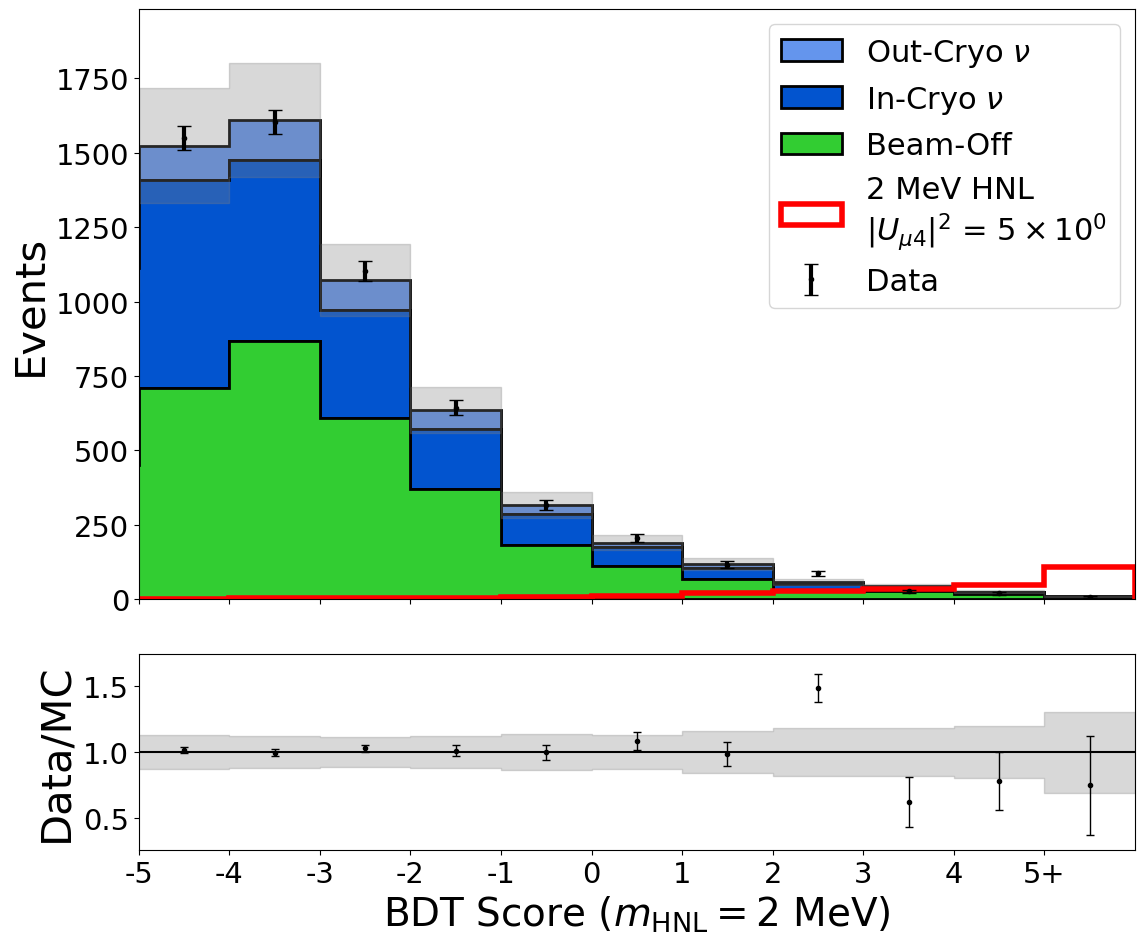

HNL scale is 60738.951069984236


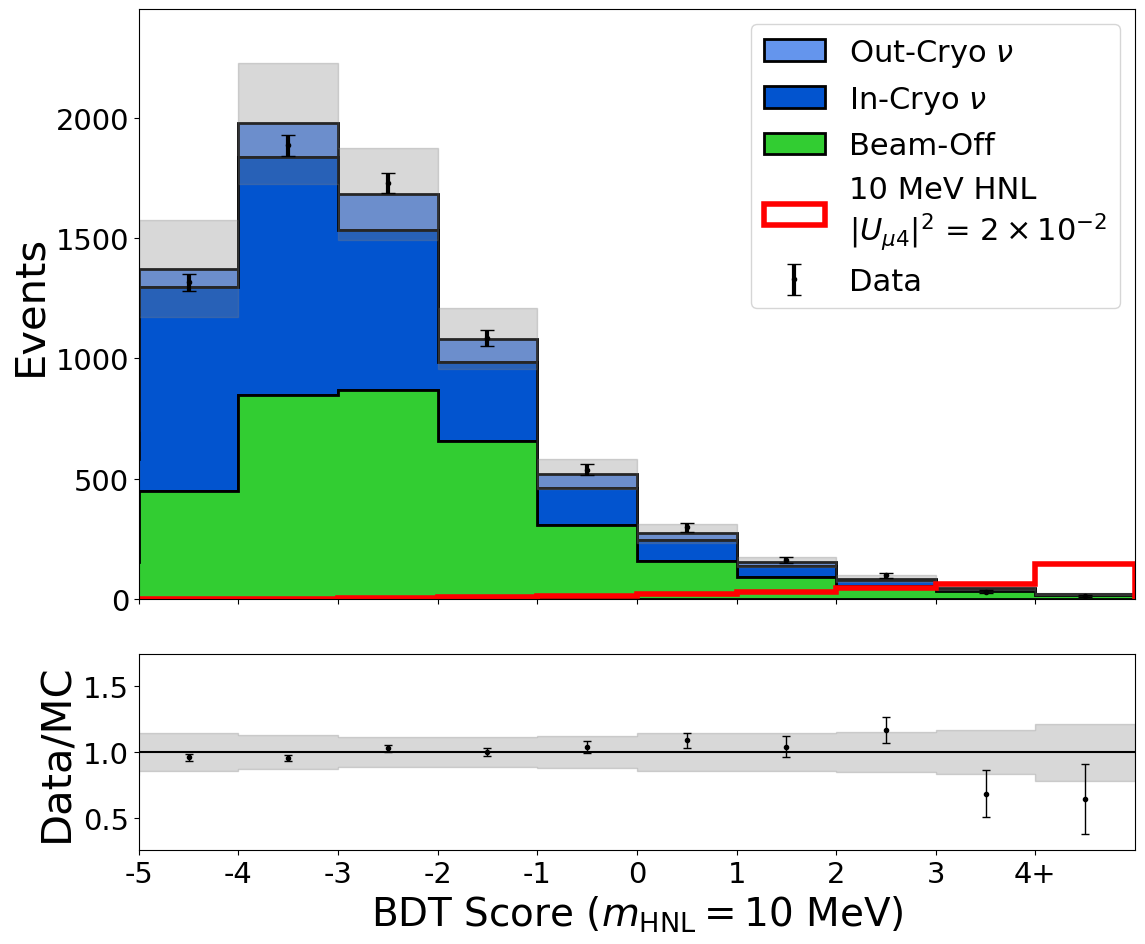

HNL scale is 102315133777.57597


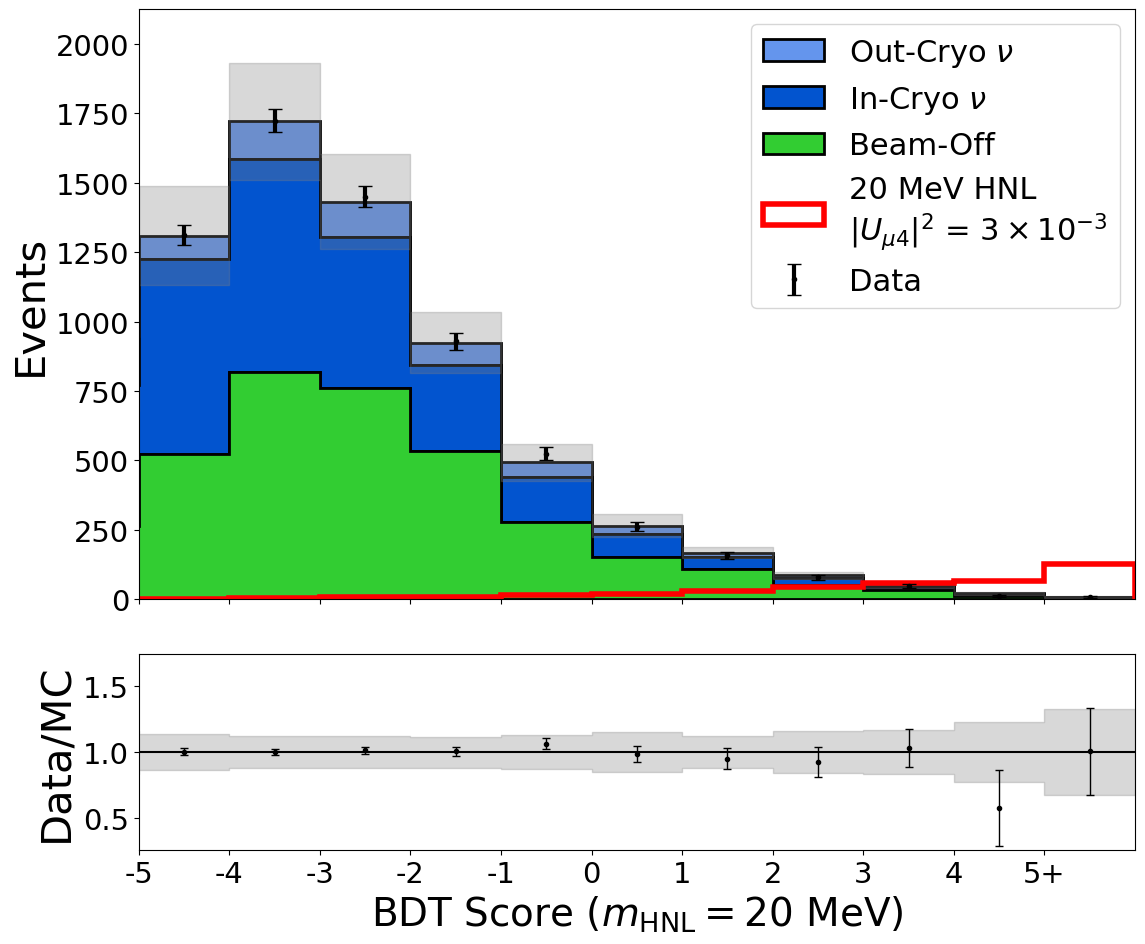

HNL scale is 323195553.04936403


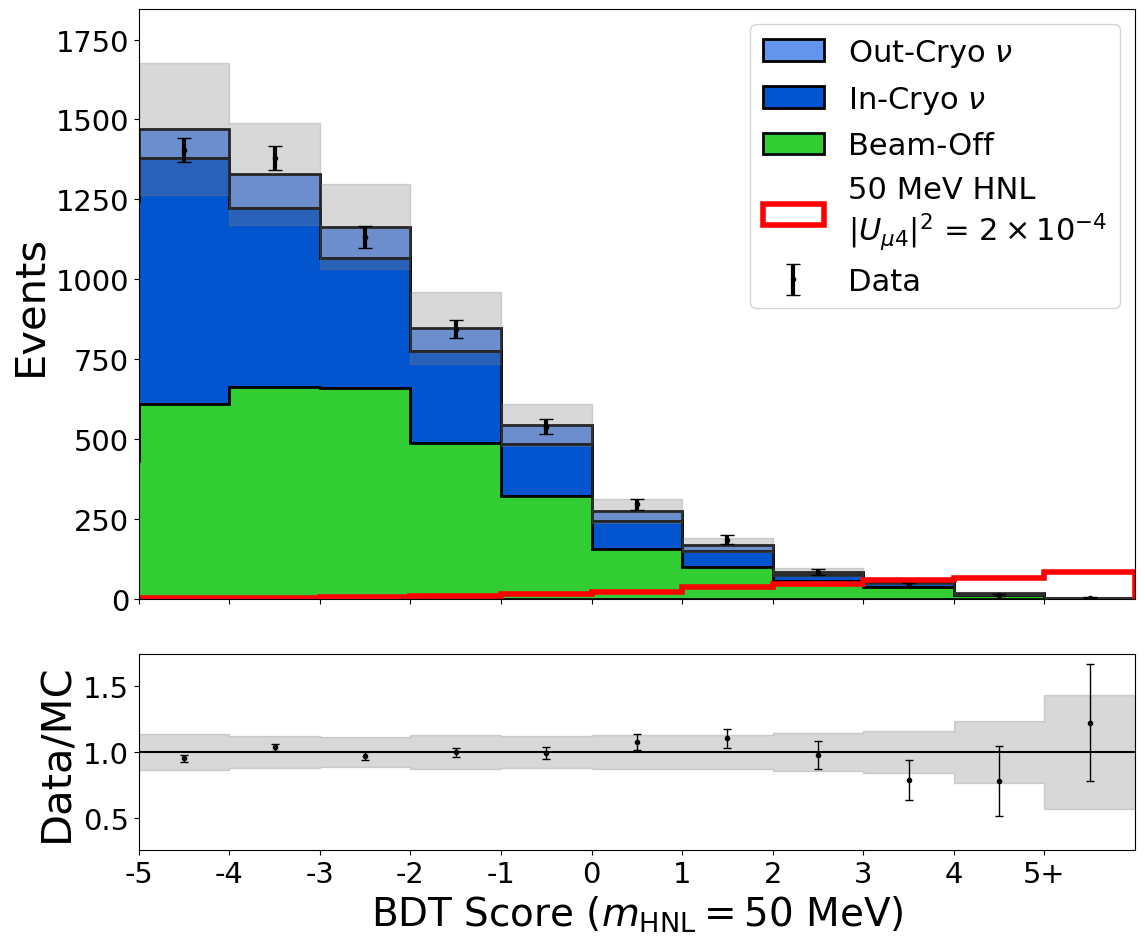

HNL scale is 4995850.96047869


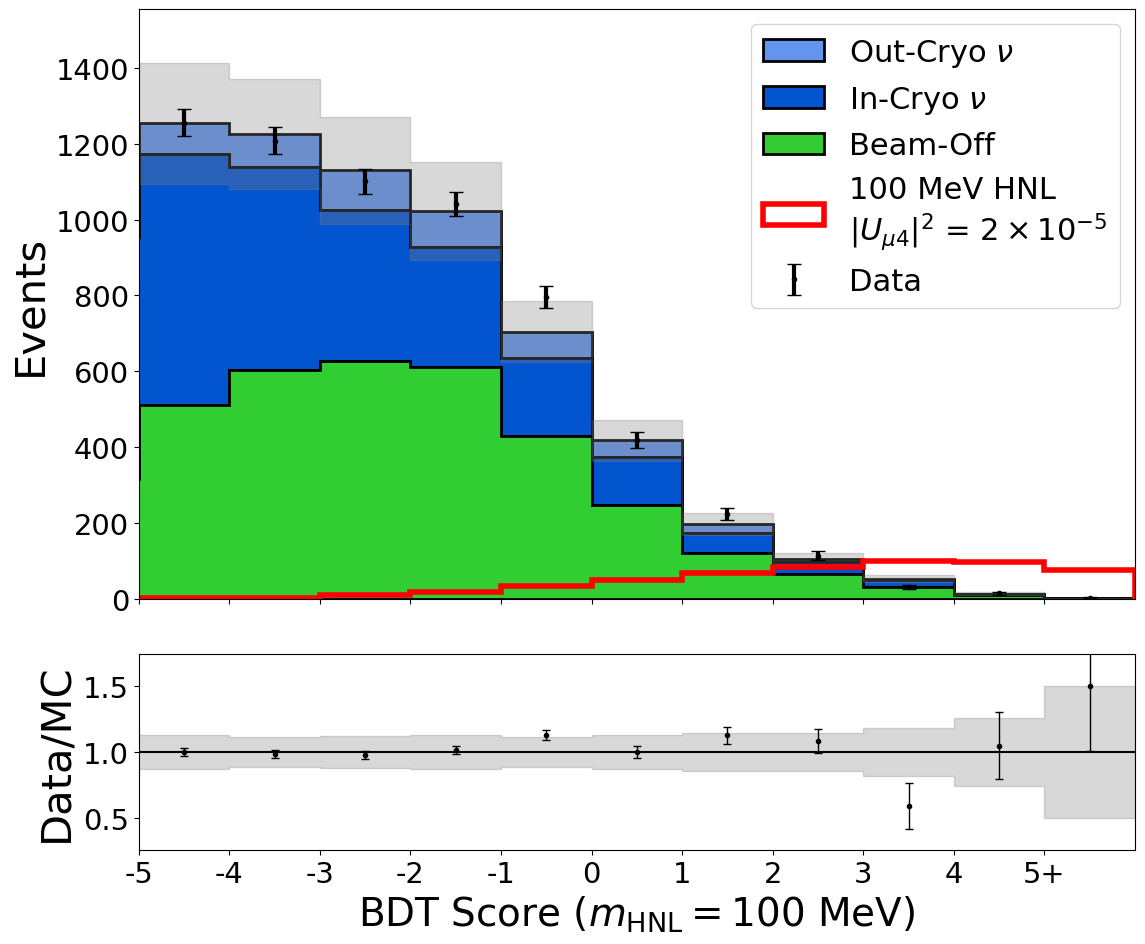

HNL scale is 286133.780604268


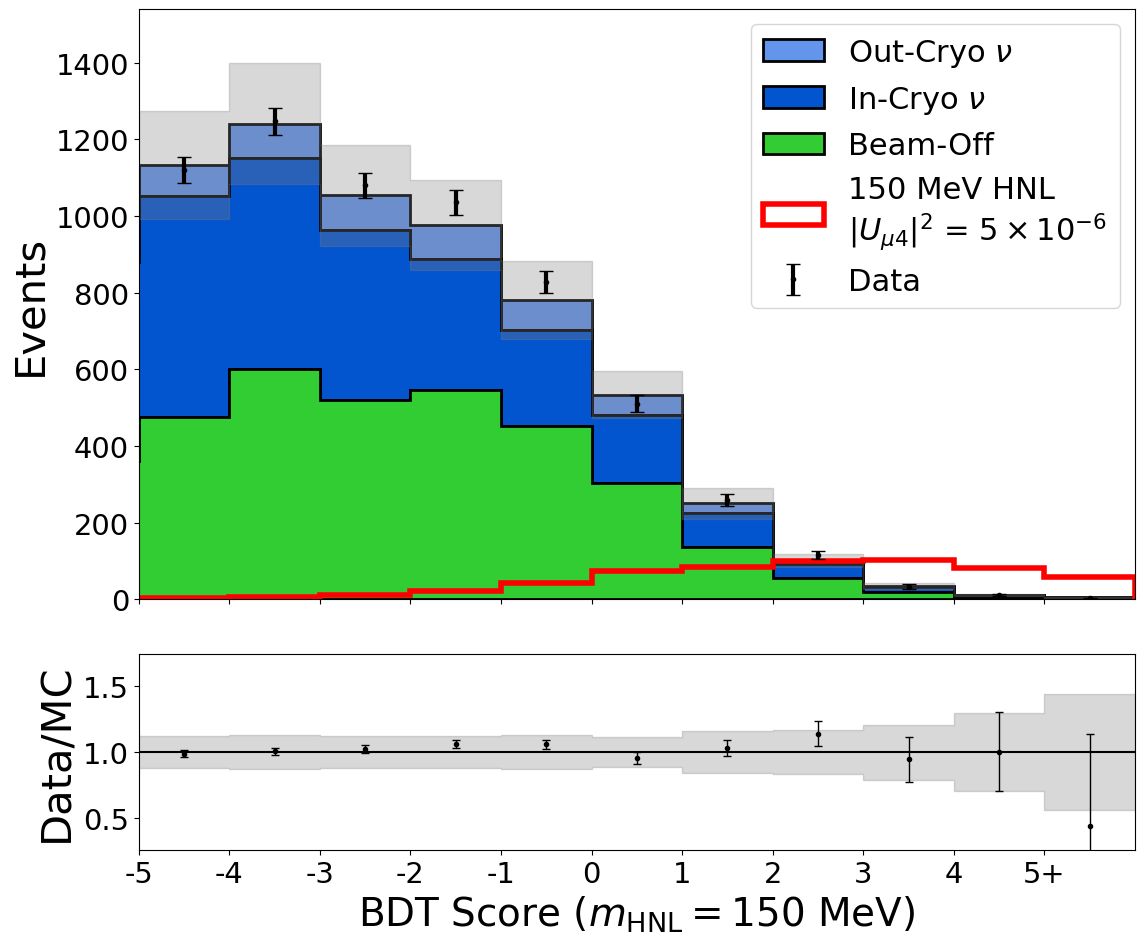

In [18]:
Run="run1"
plt.rcParams.update({'font.size': 25})
Lo_score = -5.0

adjusted_xlims_r1, xticks_r1 = make_xlims_dict(bins_overflow_r1, lower = -5)
adjusted_xlims_r3, xticks_r3 = make_xlims_dict(bins_overflow_r3, lower = -5)

if Params_pyhf["Load_lepton_hists"]==True: decay_type = "ee"
if Params_pyhf["Load_pi0_hists"]==True: decay_type = "pi0"
if Params_pyhf["Load_lepton_dirac"]==True: decay_type = "ee_dirac"
if Params_pyhf["Load_pi0_dirac"]==True: decay_type = "pi0_dirac"

savestr = f"_{decay_type}{BDT_name}_unstacked"

sample_colours_test = {'overlay':'#0254cf',
                  'dirtoverlay':'cornflowerblue',
                  'beamoff':'limegreen',
                  'signal':'red',
                  'signal_pi0':'gold'}

titlename = r"MicroBooNE NuMI Data" "\n" r"$5.01\times10^{20}$ POT"

Plot_BDT_output_systematics_data(signal_dict_r1, tot_uncertainty_dict_r1, sig_sys_err_r1, bkgs_dict_r1, data_r1, bins_cents_overflow_r1, bins_overflow_r1, 
                                 xlims=adjusted_xlims_r1, xticks=xticks_r1, upper_y=0.75, legloc="upper right", colours = sample_colours_test,
                                 legsize=22, logy=False, savefig=True, save_str=savestr, Run=Run, HNL_scale=new_hist_scaling,
                                 scale_up=new_hist_scaling, thetas=theta_dict, sig_sys=False, HNL_scale_label=True, stacked=False,
                                 title_name=None, textpos=None, plot_text=None, textsize=18)


## Run3

Scaling each mass point individually
HNL scale is 250000.0


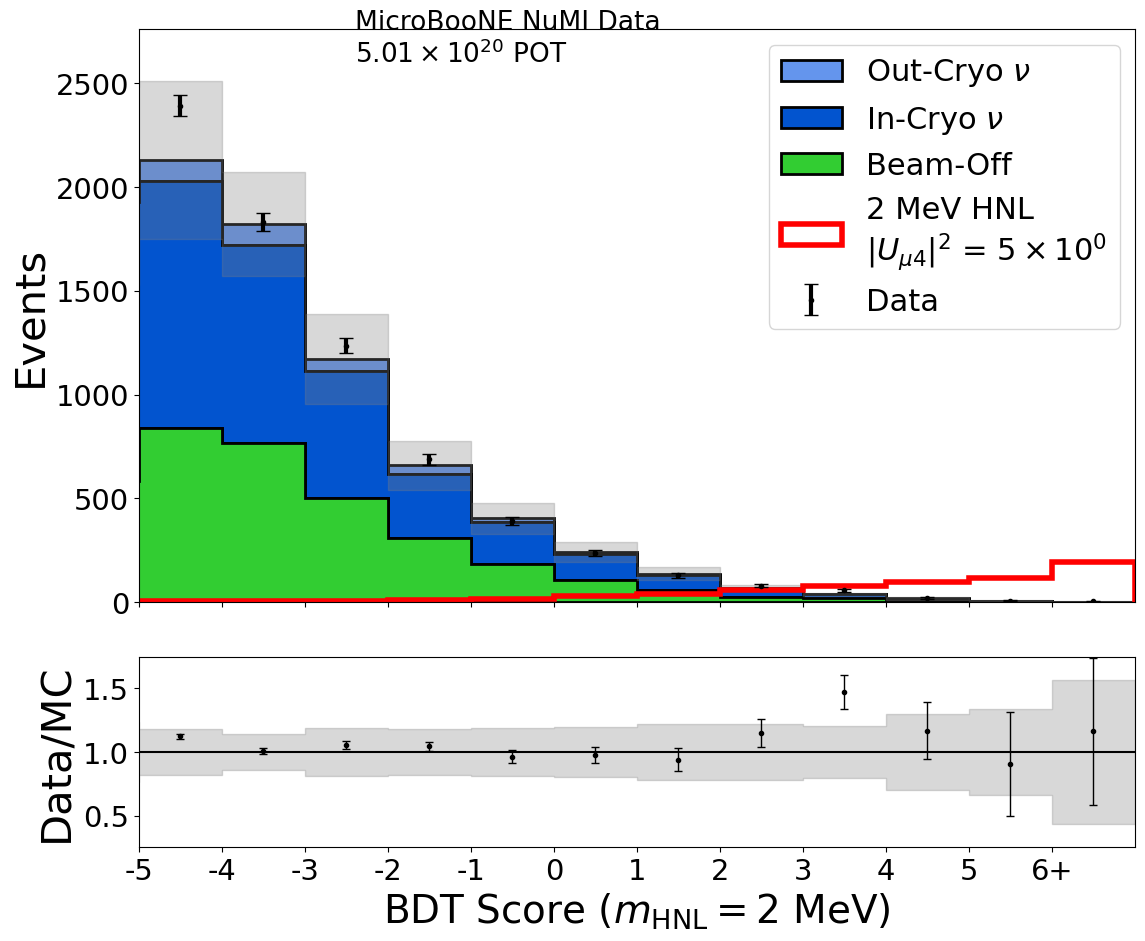

HNL scale is 60738.951069984236


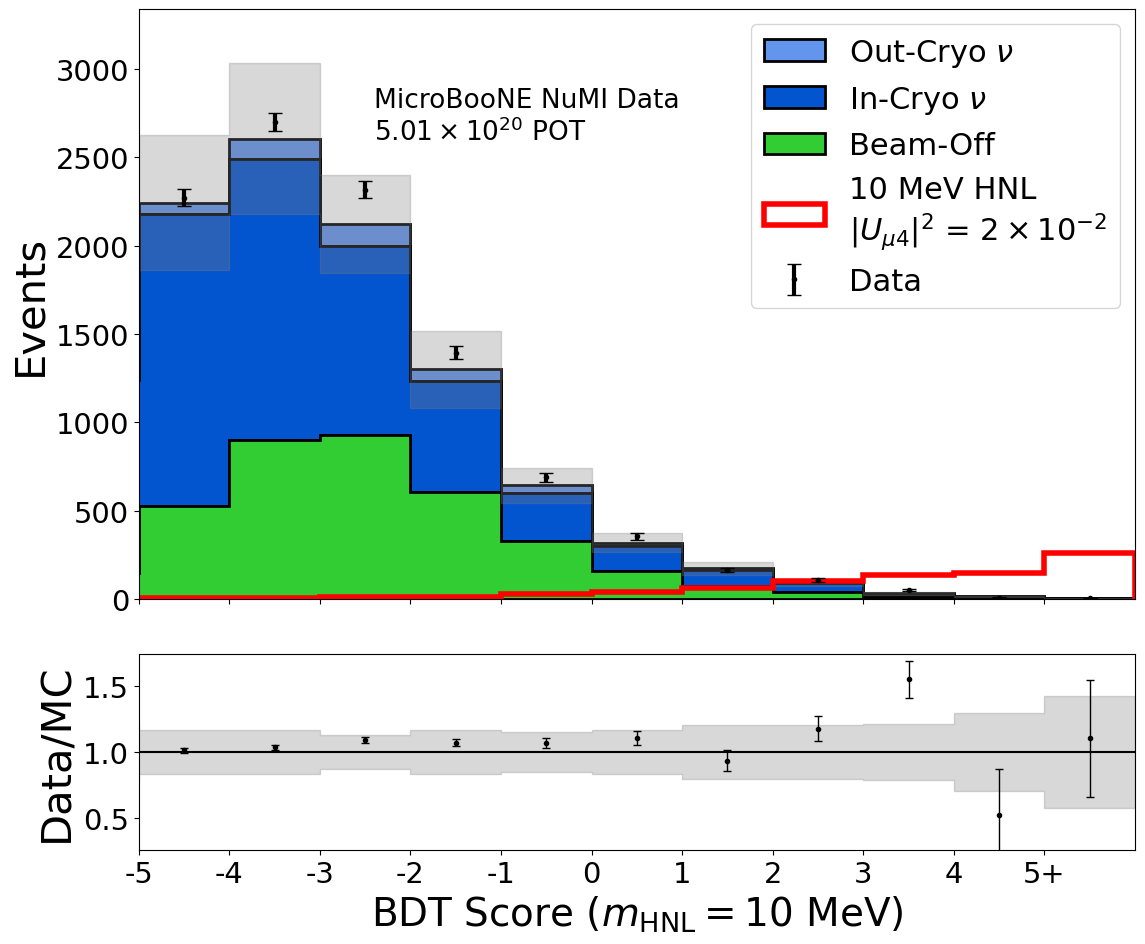

HNL scale is 102315133777.57597


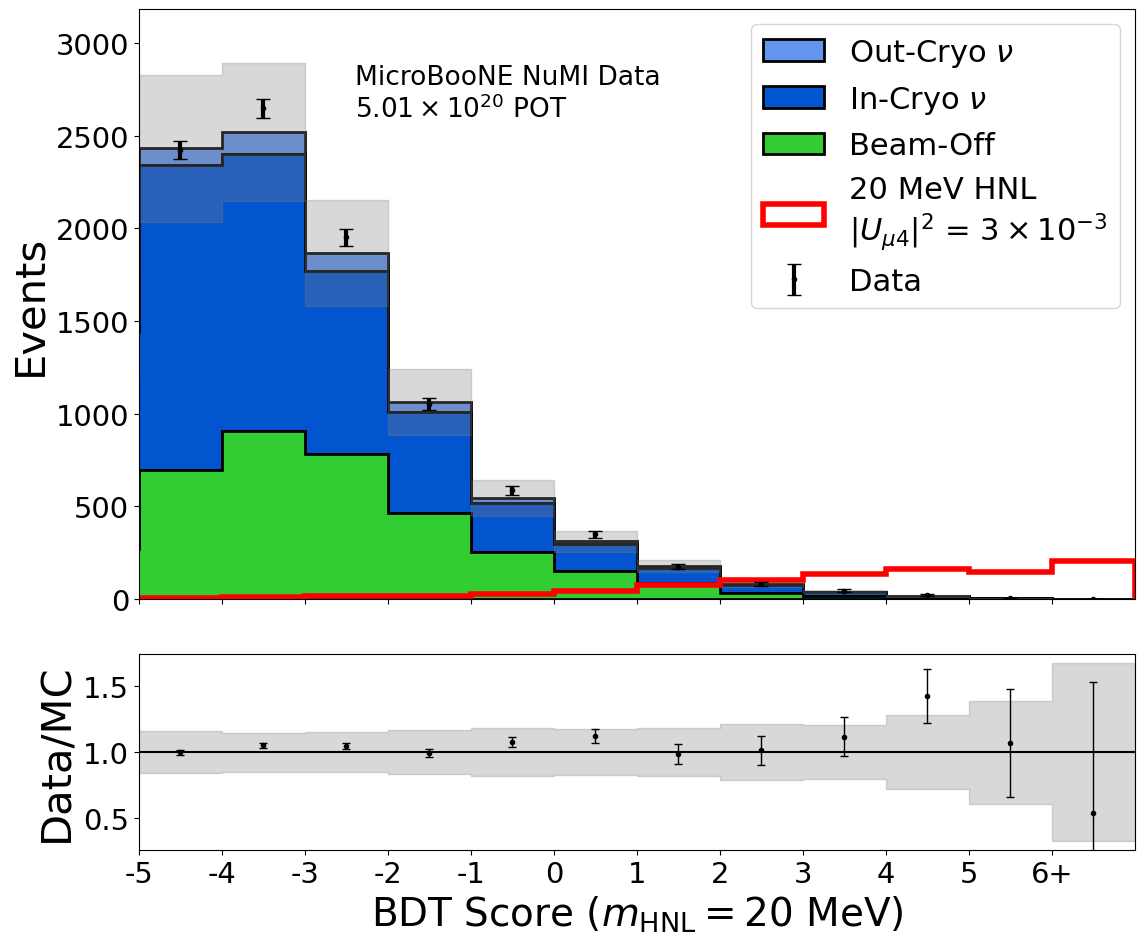

HNL scale is 323195553.04936403


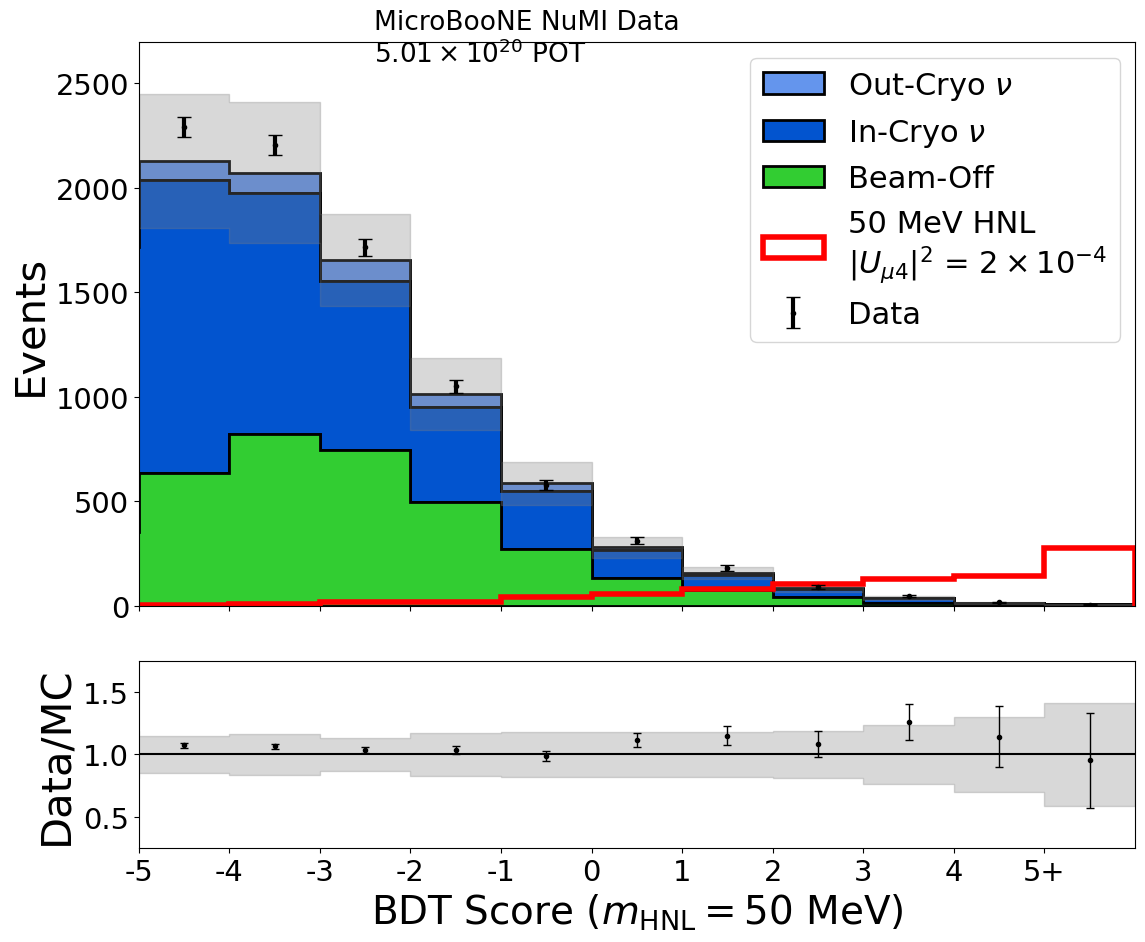

HNL scale is 4995850.96047869


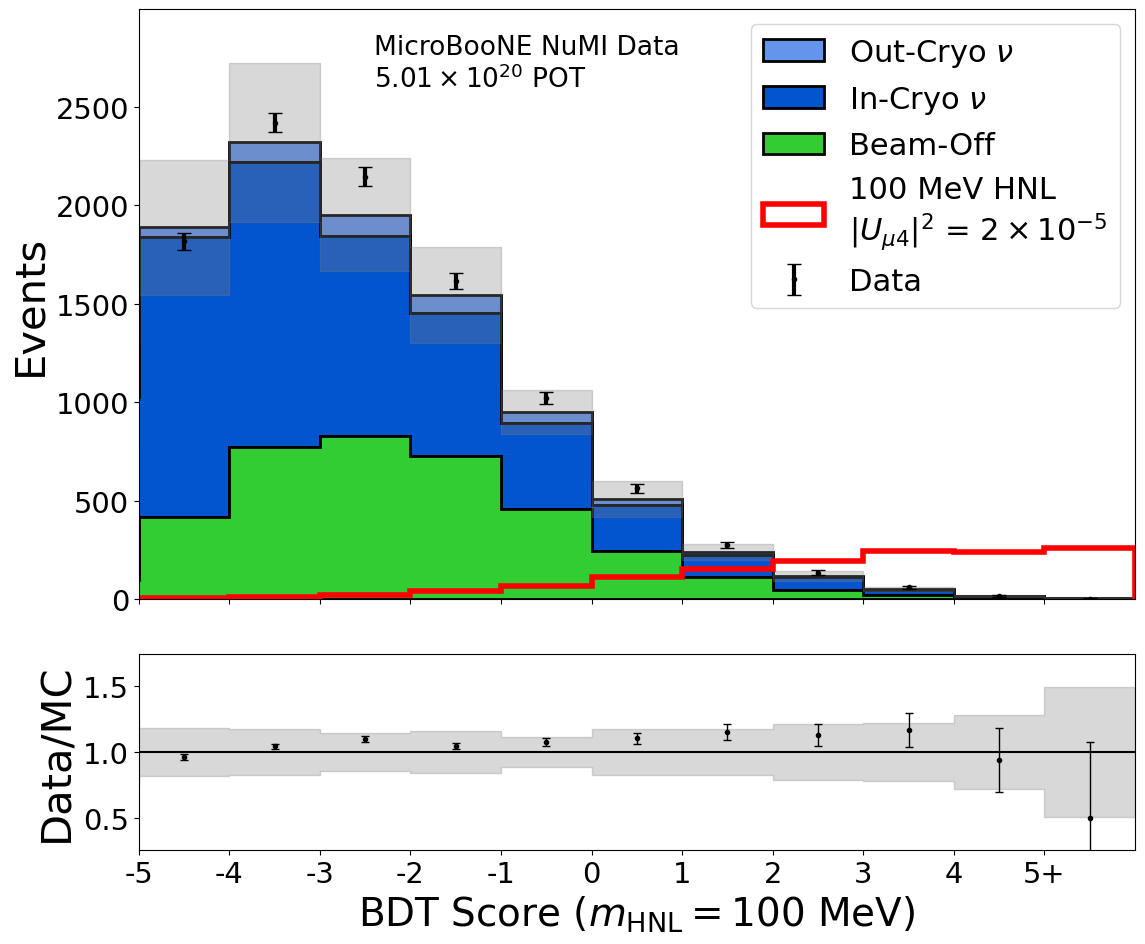

HNL scale is 286133.780604268


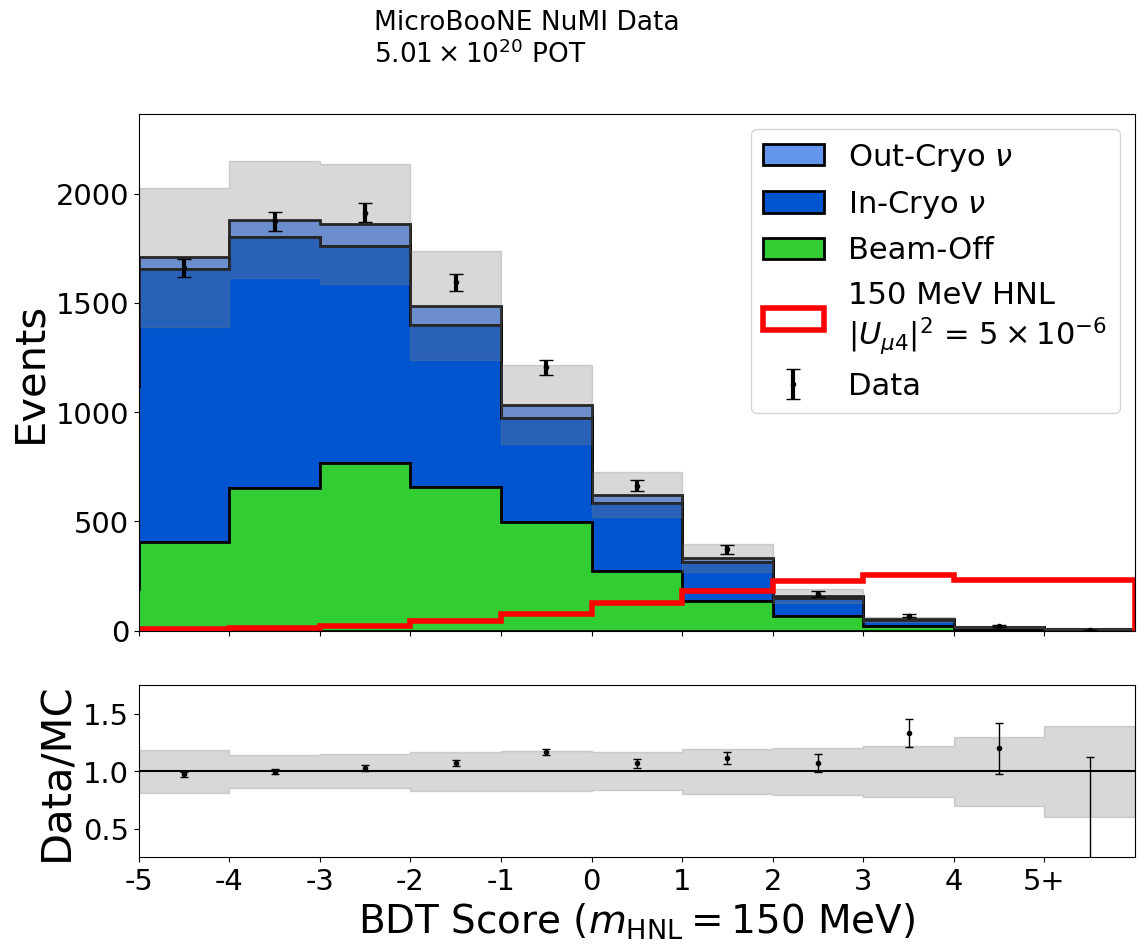

In [26]:
Run="run3"
plt.rcParams.update({'font.size': 25})

savestr = f"_{decay_type}{BDT_name}_unstacked"

Plot_BDT_output_systematics_data(signal_dict_r3, tot_uncertainty_dict_r3, sig_sys_err_r3, bkgs_dict_r3, data_r3, bins_cents_overflow_r3, bins_overflow_r3, 
                                 xlims=adjusted_xlims_r3, xticks=xticks_r3, upper_y=0.75, legloc="upper right", colours = sample_colours_test,
                                 legsize=22, logy=False, savefig=True, save_str=savestr, Run=Run, HNL_scale=new_hist_scaling,
                                 scale_up=new_hist_scaling, thetas=theta_dict, sig_sys=False, HNL_scale_label=True, stacked=False,
                                 title_name=None, textpos=[-2.4,2600], plot_text=titlename, textsize=19)



## Comparing Dirac and Majorana signal distributions

In [13]:
Params_dirac = {"Stats_only":False,
               "Use_flat_sys":False,
               "Use_part_only":False,
               "Num_bins_for_calc":4,
               "Use_toys":False,
               "Num_toys":100,
               "Load_lepton_hists":False,
               "Load_pi0_hists":False,
               "Flat_bkg_overlay_frac":0.3,
               "Flat_bkg_dirt_frac":0.75,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.2, #This is very conservative, could be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3, #This comes from the KDAR flux uncertainty.
               "Overlay_detvar_frac":0.3,
               "Load_lepton_dirac":False,
               "Load_pi0_dirac":True,
               "Load_single_r1_file":False}

Functions.pyhf_params(Params_dirac)

if Params_dirac["Load_lepton_hists"] == True: 
    name_type="ee"
    HNL_masses_dirac = Constants.HNL_mass_samples
if Params_dirac["Load_pi0_hists"] == True: 
    name_type="pi0"
    HNL_masses_dirac = Constants.HNL_mass_pi0_samples
if Params_dirac["Load_lepton_dirac"] == True:
    name_type="ee_dirac"
    HNL_masses_dirac = Constants.HNL_ee_dirac_mass_samples
if Params_dirac["Load_pi0_dirac"] == True:
    name_type="pi0_dirac"
    HNL_masses_dirac = Constants.HNL_pi0_dirac_mass_samples
    
BDT_name = "_full_Finished_10"

filename = name_type+BDT_name
print(filename)

hist_dict_run1_dirac, hist_dict_run3_dirac, theta_dict_dirac = Functions.New_Load_pyhf_files(f"{filename}.root",
                                                                                             Params_dirac, HNL_masses = HNL_masses_dirac)


Using fully evaluated systematic uncertainty for background. Dirt error is 75.0%.
Using fully evaluated systematic uncertainty for signal. Using 30.0% flux error.
pi0_dirac_full_Finished_10
Loading Dirac samples
Missing hists for Run1 are: 
['ppfx_uncertainty;1', 'Genie_uncertainty;1', 'Reinteraction_uncertainty;1', 'overlay_DetVar_uncertainty;1', 'signal_DetVar_uncertainty;1']
thetas are:
{150: 1e-04, 200: 1e-04, 245: 1e-04}
Done


In [14]:
# HNL_mass = 245

# print(signal_dict_r1_dirac[HNL_mass])
# print(len(signal_dict_r1_dirac[HNL_mass]))

# print(bins_dict_r1[HNL_mass])
# print(len(bins_dict_r1[HNL_mass]))

# print(bins_cent_dict_r1[HNL_mass])
# print(len(bins_cent_dict_r1[HNL_mass]))

# dirac_placeholder = np.histogram(bins_cent_dict_r1[HNL_mass], bins=bins_dict_r1[HNL_mass], weights=signal_dict_r1_dirac[HNL_mass])[0]
# print(dirac_placeholder)

In [15]:
signal_dict_r1_dirac, bkgs_dict_r1_dirac, data_r1_dirac, sig_sys_err_r1_dirac, tot_uncertainty_dict_r1_dirac, bins_dict_r1_dirac, bins_cent_dict_r1_dirac = Get_uncertainty_dicts(hist_dict_run1_dirac, 
                                                                                                                                                            Params_dirac)


Do you want to save the BDT score plots? y/n  y


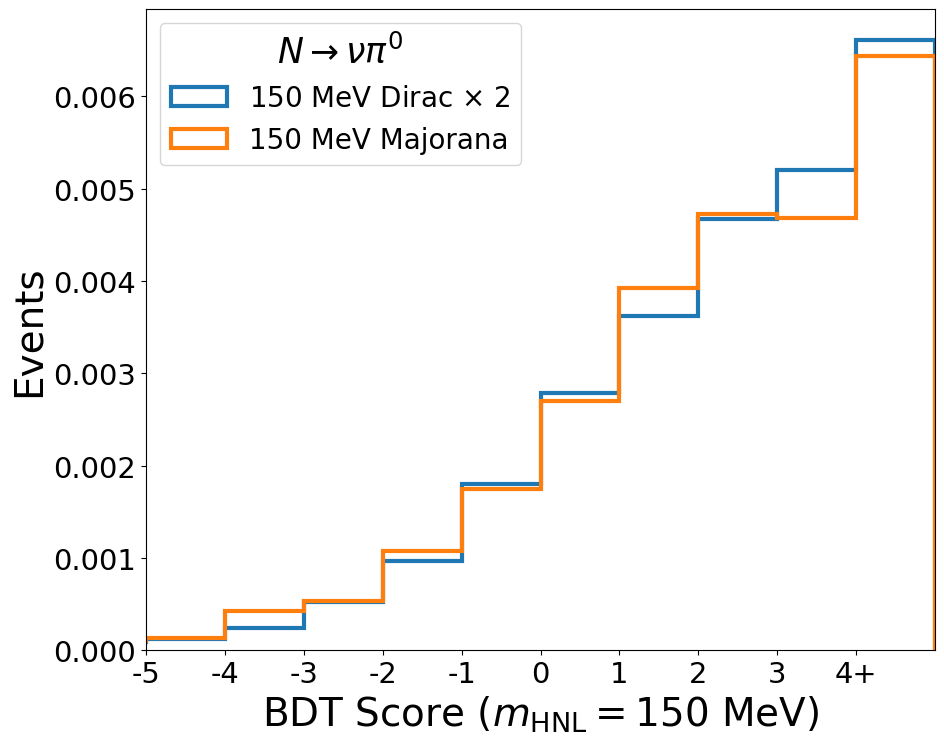

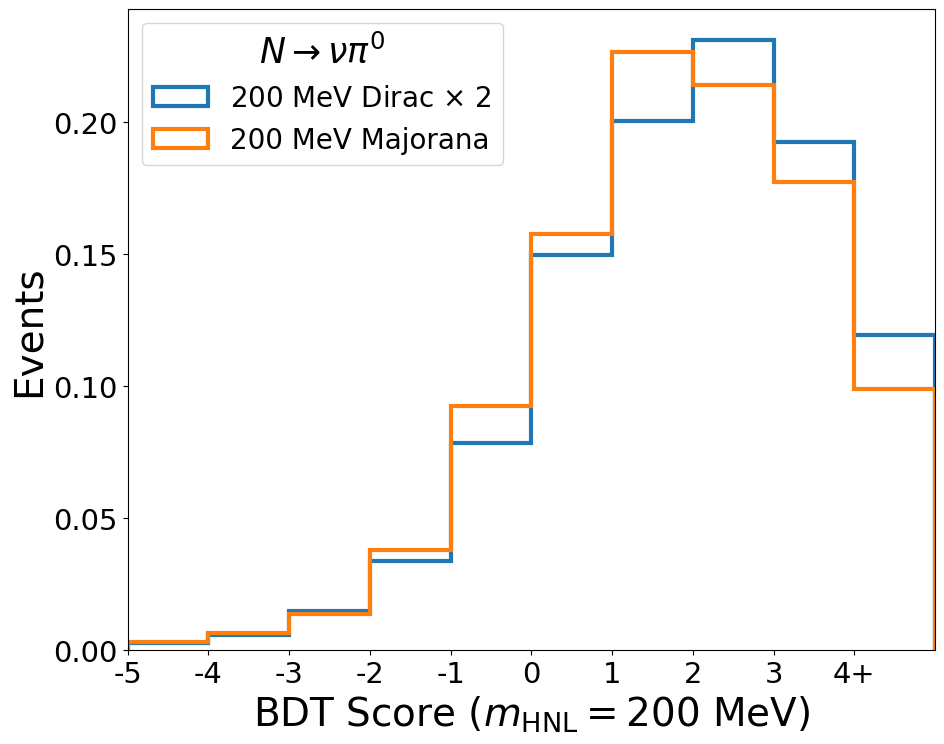

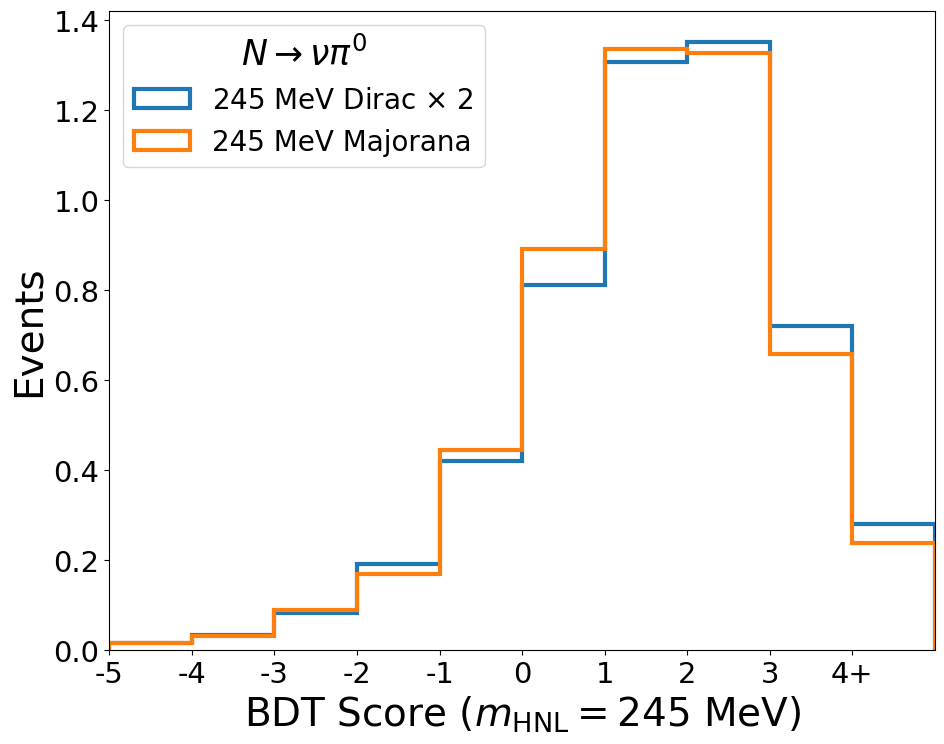

In [16]:

Dirac_factor = 2.0

Run = "run1"

# adjusted_xlims_r1, xticks_r1

savefig = input("Do you want to save the BDT score plots? y/n ")

for HNL_mass in HNL_masses_dirac:
    plt.figure(figsize=[10,8])
    xlims_plot = adjusted_xlims_r1[HNL_mass]

    weights_Dirac = signal_dict_r1_dirac[HNL_mass]*Dirac_factor
    # dirac_placeholder = np.histogram(bins_cents_overflow_r1[HNL_mass], weights=signal_dict_r1_dirac[HNL_mass], bins=bins_overflow_r1[HNL_mass])[0]
    dirac_placeholder = np.histogram(bins_cent_dict_r1[HNL_mass], bins=bins_dict_r1[HNL_mass], weights=signal_dict_r1_dirac[HNL_mass])[0]
    majorana_placeholder = np.histogram(bins_cent_dict_r1[HNL_mass], bins=bins_dict_r1[HNL_mass], weights=signal_dict_r1[HNL_mass])[0]
    plt.hist(bins_cents_overflow_r1[HNL_mass], weights=dirac_placeholder*Dirac_factor, bins=bins_overflow_r1[HNL_mass], 
             label = f"{HNL_mass} MeV Dirac " + r"$\times~2$", histtype="step", lw=3) #Tried dashed linestyle but looked weird
    plt.hist(bins_cents_overflow_r1[HNL_mass], weights=majorana_placeholder, bins=bins_overflow_r1[HNL_mass], 
             label = f"{HNL_mass} MeV Majorana", histtype="step", lw=3)
    
    plt.ylabel('Events', fontsize=28)
    
    plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=28)
    plt.xticks(ticks=np.arange(bins_overflow_r1[HNL_mass][0], bins_overflow_r1[HNL_mass][-1], 1), labels=xticks_r1[HNL_mass])
    plt.xlim(xlims_plot)
    
    # plt.legend(fontsize=20)
    
    if decay_type == "ee": text1 = r'$N\rightarrow \nu e^{+}e^{-}$'
    if decay_type == "pi0": text1 = r'$N\rightarrow \nu \pi^{0}$'   
    
    plt.legend(loc="best",frameon=True, fontsize=20, title=text1)
    
    plt.tight_layout()
    
    if savefig == "y":
        plt.savefig(f"plots/BDT_output/Dirac_vs_Majorana_scores/Dirac_vs_Majorana_BDT_output_{decay_type}_" + Run + "_" + str(HNL_mass) + "MeV.pdf")
        plt.savefig(f"plots/BDT_output/Dirac_vs_Majorana_scores/Dirac_vs_Majorana_BDT_output_{decay_type}_" + Run + "_" + str(HNL_mass) + "MeV.png")
    

In [ ]:
HNL_mass = 150

dirac_placeholder = np.histogram(bins_cents_overflow_r1[HNL_mass], weights=signal_dict_r1_dirac[HNL_mass], bins=bins_overflow_r1[HNL_mass])[0]
majorana_placeholder = np.histogram(bins_cents_overflow_r1[HNL_mass], weights=signal_dict_r1[HNL_mass], bins=bins_overflow_r1[HNL_mass])[0]

print(dirac_placeholder)
print(majorana_placeholder)

print("Ratios of bin heights:")

for i, val in enumerate(dirac_placeholder):
    ratio = dirac_placeholder[i]/majorana_placeholder[i]
    print(ratio)

## Loading in Uncertainties

In [ ]:
def Calculate_total_uncertainty(Params, hist_dict, bkg_reweight_err_dict=None, bkg_detvar_dict=None, sig_detvar_dict=None): #Takes the dictionary of all root files
    BKG_ERR_dict, SIGNAL_ERR_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_stat_err_list = [hist_dict[HNL_mass]['bkg_overlay'].errors(), 
                             hist_dict[HNL_mass]['bkg_EXT'].errors(), 
                             hist_dict[HNL_mass]['bkg_dirt'].errors()]
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True:
        #As default the errors saved in the files are stat errors, this will change once I properly calculate them
            bkg_err_list = bkg_stat_err_list
            sig_err = sig_stat_err
        elif Params["Use_flat_sys_bkg"] == True:
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['bkg_overlay'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"] + np.ones_like(hist_dict[HNL_mass]['bkg_overlay'].values())*2.0, #This is horrible need to rewrite 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            else:    
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"], 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        elif Params["Use_flat_sys_bkg"] == False:
            ppfx_unc = hist_dict[HNL_mass]["ppfx_uncertainty"].values()
            genie_unc = hist_dict[HNL_mass]["Genie_uncertainty"].values()
            reint_unc = hist_dict[HNL_mass]["Reinteraction_uncertainty"].values()
            # detvar_unc = bkg_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values() #Don't know what this looks like yet, as I haven't made
            detvar_unc = hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Overlay_detvar_frac"] #Just setting as flat. Too much variation in samples
            tot_overlay_sys = Functions.add_all_errors([ppfx_unc, genie_unc, reint_unc, detvar_unc])
            bkg_sys_err_list = [tot_overlay_sys, 
                                np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]] #Don't have reweight or DetVar samples for dirt
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == True):
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['signal'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} signal last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]+2.0
            else:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == False):
            sig_detvar_err = sig_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_overlay_bkg_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_detvar_err,sig_flux_err]) #Adding stat, detvar and flux errors in quadrature
        total_bkg_err = Functions.add_all_errors(bkg_err_list) #Now adding the errors of overlay, EXT and dirt in quadrature
        BKG_ERR_dict[HNL_mass] = total_bkg_err
        SIGNAL_ERR_dict[HNL_mass] = sig_err
    return BKG_ERR_dict, SIGNAL_ERR_dict
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict


## End of code